##### Import of the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import linearmodels as lm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

##### Definition of helper funtions

In [2]:
def error_table(model_name, y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

##### Data Preparation

In [3]:
df = pd.read_csv("../data/sales_stores.csv", parse_dates=['Date'])
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSince,Promo2,Promo2Since,PromoInterval,CompetitionTimeDays,CompetitionTimeMonths,PromoTimeWeeks
0,1,5,2015-07-31,5263,555,1,1,no_holiday,1,31,c,basic,1270.0,2008-09-01,0,NaN,NaN,2524,82,0
1,2,5,2015-07-31,6064,625,1,1,no_holiday,1,31,a,basic,570.0,2007-11-01,1,2010-03-29,"Jan,Apr,Jul,Oct",2829,93,278
2,3,5,2015-07-31,8314,821,1,1,no_holiday,1,31,a,basic,14130.0,2006-12-01,1,2011-04-04,"Jan,Apr,Jul,Oct",3164,104,225
3,4,5,2015-07-31,13995,1498,1,1,no_holiday,1,31,c,extended,620.0,2009-09-01,0,NaN,NaN,2159,70,0
4,5,5,2015-07-31,4822,559,1,1,no_holiday,1,31,a,basic,29910.0,2015-04-01,0,NaN,NaN,121,3,0


As we will aggregate the data on a weekly basis, we no longer need `DayOfWeek`.

In [4]:
df.drop('DayOfWeek', axis=1, inplace=True)

During the exploratory data analysis, we realized that some variables would not be of much use to us:

In [5]:
df.drop(['Promo2', 'Promo2Since', 'PromoInterval', 'CompetitionDistance', 'CompetitionOpenSince', 'CompetitionTimeDays', 'CompetitionTimeMonths'], axis=1, inplace=True)

One-hot encoding for categorical variables:

In [6]:
df = pd.get_dummies(df, dtype='int')
# No holiday = all zeroes on the StateHoliday columns
df.drop('StateHoliday_no_holiday', axis=1, inplace=True)
df.columns

Index(['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'WeekOfYear', 'PromoTimeWeeks', 'StateHoliday_christmas',
       'StateHoliday_easter', 'StateHoliday_public_holiday', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_basic',
       'Assortment_extended', 'Assortment_extra'],
      dtype='object')

##### Weekly aggregation

We make `Date` the index:

In [7]:
df.set_index('Date', inplace=True)
# Now we have a DataFrame for each date:
#df.loc['2013-01-01']

Let's aggregate the data on a weekly basis:

In [8]:
# The anchored offset W would give sunday weekly frequency
by_week_store = df.groupby([pd.Grouper(freq='W-Mon'), 'Store'])

sum_cols = by_week_store[['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday_christmas', 
                          'StateHoliday_easter', 'StateHoliday_public_holiday']].sum()

fix_cols = by_week_store[['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_basic', 
                          'Assortment_extended', 'Assortment_extra','WeekOfYear', 'PromoTimeWeeks']].first()

week_df = pd.concat([sum_cols, fix_cols], axis=1)

week_df.head()

# With code like this we can check that it has worked fine:
#foo = df.loc['2013-01-01':'2013-01-07']
#foo[foo['Store']  == 1]['Sales'].sum()

Sales  Customers  Open  Promo  SchoolHoliday  \
Date       Store                                                 
2013-01-07 1      26516       3285     5      1              5   
           2      22182       2866     5      1              3   
           3      35564       3820     5      1              3   
           4      48928       6985     5      1              3   
           5      20742       2520     5      1              1   

                  StateHoliday_christmas  StateHoliday_easter  \
Date       Store                                                
2013-01-07 1                           0                    0   
           2                           0                    0   
           3                           0                    0   
           4                           0                    0   
           5                           0                    0   

                  StateHoliday_public_holiday  StoreType_a  StoreType_b  \
Date       Store                                                          
2013-01-07 1                                0            0            0   
           2                                0            1            0   
           3                                0            1            0   
           4                                0            0            0   
           5                                0            1            0   

                  StoreType_c  StoreType_d  Assortment_basic  \
Date       Store                                               
2013-01-07 1                1            0                 1   
           2                0            0                 1   
           3                0            0                 1   
           4                1            0                 0   
           5                0            0                 1   

                  Assortment_extended  Assortment_extra  WeekOfYear  \
Date       Store                                                      
2013-01-07 1                        0                 0           2   
           2                        0                 0           2   
           3                        0                 0           2   
           4                        1                 0           2   
           5                        0                 0           2   

                  PromoTimeWeeks  
Date       Store                  
2013-01-07 1                   0  
           2                 145  
           3                  92  
           4                   0  
           5                   0

`Date`now shows us the Monday of the corresponding week, while the remaining variables each show the weekly total of the previous week. But I would like to have the previous Monday instead.

In [9]:
# Return temporarily to a sequential index
week_df = week_df.reset_index()
week_df['Date'] = week_df['Date'] - pd.Timedelta(days=7)
week_df.head()

,Date,Store,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_christmas,StateHoliday_easter,StateHoliday_public_holiday,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_basic,Assortment_extended,Assortment_extra,WeekOfYear,PromoTimeWeeks
0,2012-12-31,1,26516,3285,5,1,5,0,0,0,0,0,1,0,1,0,0,2,0
1,2012-12-31,2,22182,2866,5,1,3,0,0,0,1,0,0,0,1,0,0,2,145
2,2012-12-31,3,35564,3820,5,1,3,0,0,0,1,0,0,0,1,0,0,2,92
3,2012-12-31,4,48928,6985,5,1,3,0,0,0,0,0,1,0,0,1,0,2,0
4,2012-12-31,5,20742,2520,5,1,1,0,0,0,1,0,0,0,1,0,0,2,0


In [10]:
# Create a time series for the number of observations per date
#obs_by_date = week_df.groupby('Date').size()

#total_weeks = 0
#data_points = 0
#for no_stores in obs_by_date.unique():
#    no_weeks = obs_by_date[obs_by_date == no_stores].size
#    total_weeks += no_weeks
#    data_points += no_weeks*no_stores
#    print("There are {} Week(s) with {} observed stores.".format(no_weeks, no_stores))

#print("There are {} Weeks in total.".format(total_weeks))
#print("And there are {} data points in total.".format(data_points))

The number of days a Store is open in a week has an obvious influence on the number of clients. Because of that it seems reasonable to drop the `Open` column.

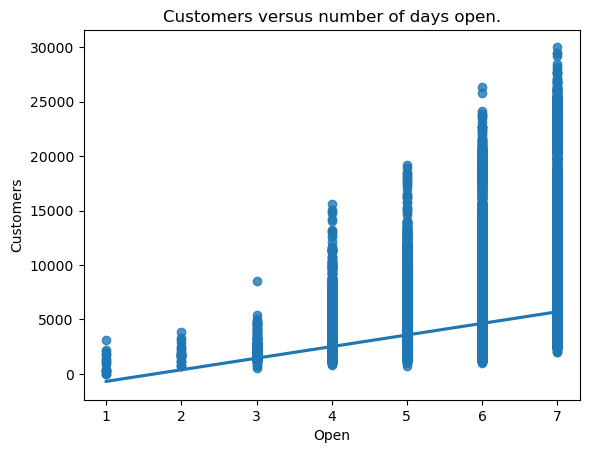

In [11]:
sns.regplot(x='Open', y='Customers', data=week_df).set(title="Customers versus number of days open.");

In [12]:
week_df.drop('Open', axis=1, inplace=True)

We log-scale 'Sales' and 'Customers' because they have a large range of values and theirdistributions are skewed towards long values:

In [13]:
week_df['Sales'] = np.log1p(week_df['Sales'])
week_df['Customers'] = np.log1p(week_df['Customers'])

##### Split dataframe into training and test

In [14]:
week_df.sort_values(by=['Date', 'Store'], ascending=[False, True], inplace=True)
# Multiindex
week_df.set_index(['Store', 'Date'], inplace=True)

In [15]:
# 8 weeks before the last date
test_date = week_df.index[0][1]- datetime.timedelta(weeks=7)

X_test =week_df[week_df.index.get_level_values(1) >= test_date].drop('Sales', axis=1)
X_train =week_df[week_df.index.get_level_values(1) < test_date].drop('Sales', axis=1)

y_test =week_df['Sales'][week_df.index.get_level_values(1) >= test_date]
y_train =week_df['Sales'][week_df.index.get_level_values(1) < test_date]

##### Averages Model

In [16]:
stores_mean_sales = pd.DataFrame(week_df['Sales'].groupby(level=['Store']).mean().rename('Predictions'))
y_avg = pd.DataFrame(y_test).join(stores_mean_sales)['Predictions']

error_table( 'Averages Model', np.expm1(y_test), np.expm1(y_avg))

,Model Name,MAE,MAPE,RMSE
0,Averages Model,4185.363582,0.10639,5748.669594


##### Pooled Regression Model with OLS

In [17]:
# Add a column with ones
X_pr_train = sm.add_constant(X_train)
X_pr_test = sm.add_constant(X_test)

# avoid dummy variable trap
X_pr_train.drop(['StoreType_a', 'Assortment_basic'], axis=1, inplace=True)
X_pr_test.drop(['StoreType_a', 'Assortment_basic'], axis=1, inplace=True)

# scale variables
mm_scaler = MinMaxScaler()
cols_to_scale = ['Promo', 'SchoolHoliday', 'StateHoliday_christmas', 'StateHoliday_easter', 'StateHoliday_public_holiday']
X_pr_train[cols_to_scale] = mm_scaler.fit_transform(X_pr_train[cols_to_scale])
X_pr_test[cols_to_scale] = mm_scaler.fit_transform(X_pr_test[cols_to_scale])

In [18]:
# estimate the model
pool_reg = lm.panel.PooledOLS(y_train, X_pr_train).fit()
print(pool_reg)
# estimate the model with another package
#pool_reg = sm.OLS(y_train, X_pr_train).fit()
#print(pool_reg.summary())

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Sales   R-squared:                        0.8235
Estimator:                  PooledOLS   R-squared (Between):              0.8092
No. Observations:              136726   R-squared (Within):               0.8769
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.8235
Time:                        15:11:57   Log-likelihood                 6.631e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.906e+04
Entities:                        1115   P-value                           0.0000
Avg Obs:                       122.62   Distribution:               F(13,136712)
Min Obs:                       97.000                                           
Max Obs:                       127.00   F-statistic (robust):          4.906e+04
                            

In [19]:
y_pr = pool_reg.predict(X_pr_test)
error_table( 'Pooled Regression with OLS', np.expm1(y_test), np.expm1(y_pr))

,Model Name,MAE,MAPE,RMSE
0,Pooled Regression with OLS,4822.707137,0.119161,6466.99266


##### Simple Linear Regression for each Store

In [20]:
# revert to single index on date
week_df_1 = week_df.reset_index(level=[0])
# drop columns which are fixed for a given store
week_df_1.drop(['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_basic', 'Assortment_extended', 'Assortment_extra'], axis=1, inplace=True)
# 8 weeks before the last date
test_date = week_df.index[0][1]- datetime.timedelta(weeks=7)

mm_scaler = MinMaxScaler()
cols_to_scale = ['Promo', 'SchoolHoliday', 'StateHoliday_christmas', 'StateHoliday_easter', 'StateHoliday_public_holiday']

y_lr_test_list = []
y_lr_pred_list = []
for store in np.sort(week_df_1['Store'].unique()):
    # a time series per store 
    store_mask = week_df_1['Store'] == store
    store_df = week_df_1[store_mask]
    # train and test dataframes
    X_test = store_df[store_df.index >= test_date].drop('Sales', axis=1)
    X_train = store_df[store_df.index < test_date].drop('Sales', axis=1)
    y_test = store_df['Sales'][store_df.index >= test_date]
    y_train = store_df['Sales'][store_df.index < test_date]
    # scale variables
    X_train[cols_to_scale] = mm_scaler.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = mm_scaler.fit_transform(X_test[cols_to_scale])
    # Fit a linear regression and make prerdictions.
    lr = LinearRegression().fit(X_train, y_train)
    y_pred = pd.Series(lr.predict(X_test), y_test.index)
    
    # append to lists
    y_lr_test_list.append(y_test)
    #y_lr_train.append(y_train)
    y_lr_pred_list.append(y_pred)

# concatenate series
y_lr_test = pd.concat(y_lr_test_list)
y_lr_pred = pd.concat(y_lr_pred_list)

error_table( 'LinearRegression per Store', np.expm1(y_lr_test), np.expm1(y_lr_pred))

,Model Name,MAE,MAPE,RMSE
0,LinearRegression per Store,1664.363977,0.041708,2288.657685


##### What's next?